In [25]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [26]:
# this version accepts all images, both good and bad, the bad ones have labels -1, -1
# this notebook has just quick CNN training
import tensorflow as tf
import numpy as np
import json
#%matplotlib notebook
import matplotlib.pyplot as plt
import time
import cv2
import math
import itertools
import quadprops as qps
import imganalysis as ia
import importlib
import sys
import os

In [27]:
importlib.reload(qps)

<module 'quadprops' from 'C:\\Code\\MyRepo\\ChbCapture\\08_CNNs\\2019_07_24_quad_proposals_pipeline\\quadprops.py'>

In [28]:
importlib.reload(ia)

<module 'imganalysis' from 'C:\\Code\\MyRepo\\ChbCapture\\08_CNNs\\2019_07_24_quad_proposals_pipeline\\imganalysis.py'>

In [29]:
tf.reset_default_graph()

In [30]:
saver = tf.train.import_meta_graph('./nets/28_renamed.ckpt.meta', import_scope="cornerdet")
sess_cornerdet = tf.Session()
saver.restore(sess_cornerdet, './nets/28_renamed.ckpt')

INFO:tensorflow:Restoring parameters from ./nets/28_renamed.ckpt


In [31]:
#rejector_name = './nets_rejector/67_rejector_better_converged_04.ckpt'
rejector_name = './nets_rejector/75_rejector_v04.ckpt'
saver2 = tf.train.import_meta_graph(rejector_name + '.meta', import_scope="rejector")
sess_rejector = tf.Session()
saver2.restore(sess_rejector, rejector_name)

INFO:tensorflow:Restoring parameters from ./nets_rejector/75_rejector_v04.ckpt


In [32]:
recognizer_fname = "./nets_recognizer/recognizer_83_renamed.ckpt"
saver3 = tf.train.import_meta_graph(recognizer_fname + ".meta", import_scope="recognizer")
sess_recognizer = tf.Session()
saver3.restore(sess_recognizer, recognizer_fname)

INFO:tensorflow:Restoring parameters from ./nets_recognizer/recognizer_83_renamed.ckpt


In [33]:
def dump_err_imgs(code_strs, err_codes, suspect_cnt):
    for i, code in enumerate(code_strs):
        if code in err_codes:
            fname = "out/err/%06i" % suspect_cnt
            cv2.imwrite(fname + ".pgm", accept_imgs[i,:,:,0])
            with open(fname + ".txt", "w") as f:
                print(code, file=f)
            suspect_cnt += 1
    return suspect_cnt

In [34]:
#folder_name = r"c:\Dropbox\edit\python\cws_detector\more_imgs" + "\\"

In [35]:
folder_name = r"F:\WorkingCopy2\2019_04_16_8CamsCapture\Converted\D" + '\\'

In [36]:
#out_folder_name = r"e:\2019_06_18_out\A" + "\\"
out_folder_name = r"out/"

In [37]:
folder_name

'F:\\WorkingCopy2\\2019_04_16_8CamsCapture\\Converted\\D\\'

In [38]:
out_folder_name
os.makedirs(out_folder_name, exist_ok=True)

In [39]:
logf = sys.stdout
#logf = open("out/log028_A.txt", "w")

In [53]:
valid_codes = ia.valid_codes_set('CID/CID_list.txt')
corners_PDF = True
quads_PDF = True
quad_props_PDF = True
suspect_cnt = 0
dbg_img = 2627
#for img_num in range(1350, 3500):
for img_num in range(dbg_img, dbg_img + 1):
    fname = "%s%05i.pgm" % (folder_name, img_num)
    print(file=logf)
    print(fname, file=logf)

    st_time = time.time()
    img = cv2.imread(fname)    
    print(img.shape, file=logf)
    crops, i_list, j_list = qps.gen_crops(img)
  
    (d4a, d4b) = ia.cornerdet_inference(sess_cornerdet, crops)
    assert(d4a.shape[0] == d4b.shape[0] and len(i_list) == d4a.shape[0] and len(j_list) == d4a.shape[0])

    corners, confids = ia.extract_corners_confids(d4a, d4b, i_list, j_list)
    corners, confids = qps.cluster_points_with_confidences(corners, confids)
    
    if corners_PDF:
        fig, ax = plt.subplots()
        ax.imshow(img, vmin=0, vmax=255, interpolation = 'nearest')
        ax.plot(corners[:,0], corners[:,1], 'x', color='red', markeredgewidth = 0.06, markersize=1)    
        fig.savefig(out_folder_name + "%05i_corners.pdf" % img_num, dpi = 2000)
        plt.close()

    min_dist, _, _ = qps.get_min_pair(corners)    
    
    hull_list = qps.quad_proposals(corners, min_area = 0, min_edge_len=12)
    qp = qps.hull_list_to_qp(hull_list)
    
    print("min_dist = %.2f, num_qps = %i" % (min_dist, len(qp)), file=logf)
    if min_dist < 5:
        print("Warning: min_dist too low", file=logf)
    logf.flush()
        
    if len(qp) == 0:
        print("empty qp, quitting", file=logf)
        logf.flush()
        continue
    
    img_list = []
    qv_list = [] # (proposed) quad vertices
    qi_list = [] # (proposed) quad indices
    for _, item in enumerate(qp):
        qv_img = corners[item, :]    
        wimg = qps.warped_subimage(img, qv_img)        

        qi_list.append(item)
        img_list.append(wimg)
        qv_list.append(qv_img)

    qi_arr = np.array(qi_list)
    qv_arr = np.array(qv_list)
    qp_imgs = np.array(img_list)
        
    if quad_props_PDF:
        fig, ax = plt.subplots()
        ax.imshow(img, vmin=0, vmax=255, interpolation = 'nearest')
        for i in range(qv_arr.shape[0]):
            qpoints = qv_arr[i, :, :]            
            qps.draw_quad(ax, qpoints)
        fig.savefig(out_folder_name + "%05i_quad_props.pdf" % img_num, dpi = 2000)        
        plt.close()
    
    rejector_logits = ia.run_rejector(sess_rejector, qp_imgs)
    qp_accepted = rejector_logits > 0
    accept_indices = np.flatnonzero(qp_accepted)
    accept_imgs = qp_imgs[accept_indices, :, :, :]
    accept_qv = qv_arr[accept_indices, :, :]
    accept_qi = qi_arr[accept_indices, :]
    
    code_strs = ia.run_recognizer(sess_recognizer, accept_imgs)
    print(time.time() - st_time, file=logf)
    assert(accept_qi.shape[0] == len(code_strs))
    err_codes = set()
    ia.check_code_duplicates(code_strs, logf, err_codes)
    ia.check_CIDs(code_strs, accept_qi, valid_codes, logf, err_codes)
    #print(err_codes, file=logf)
    suspect_cnt = dump_err_imgs(code_strs, err_codes, suspect_cnt)
    
    if quads_PDF:
        fig, ax = plt.subplots()
        ax.imshow(img, vmin=0, vmax=255, interpolation = 'nearest')
        for i in range(len(code_strs)):
            qpoints = accept_qv[i, :, :]            
            qps.draw_quad(ax, qpoints)
            ax.text(np.mean(qpoints[:,0]), np.mean(qpoints[:,1]), code_strs[i], \
                    verticalalignment='center', horizontalalignment='center', fontsize=1, 
                    fontweight='ultralight', color='yellow', alpha=0.75)
        fig.savefig(out_folder_name + "%05i_quads.pdf" % img_num, dpi = 2000)
        fig.clf()
        ax.cla()
        plt.close('all')
        del fig
        del ax
    
    logf.flush()


F:\WorkingCopy2\2019_04_16_8CamsCapture\Converted\D\02627.pgm
(2160, 4000, 3)
min_dist = 10.10, num_qps = 28240
61.5812668800354


In [ ]:
#Changed script

valid_codes = ia.valid_codes_set('CID/CID_list.txt')
corners_PDF = True
quads_PDF = True
quad_props_PDF = True
suspect_cnt = 0
dbg_img = 2627
#for img_num in range(1350, 3500):
for img_num in range(dbg_img, dbg_img + 1):
    fname = "%s%05i.pgm" % (folder_name, img_num)
    print(file=logf)
    print(fname, file=logf)

    st_time = time.time()
    img = cv2.imread(fname)    
    print(img.shape, file=logf)
    crops, i_list, j_list = qps.gen_crops(img)
  
    (d4a, d4b) = ia.cornerdet_inference(sess_cornerdet, crops)
    assert(d4a.shape[0] == d4b.shape[0] and len(i_list) == d4a.shape[0] and len(j_list) == d4a.shape[0])

    corners, confids = ia.extract_corners_confids(d4a, d4b, i_list, j_list)
    corners, confids = qps.cluster_points_with_confidences(corners, confids)
    
    if corners_PDF:
        fig, ax = plt.subplots()
        ax.imshow(img, vmin=0, vmax=255, interpolation = 'nearest')
        ax.plot(corners[:,0], corners[:,1], 'x', color='red', markeredgewidth = 0.06, markersize=1)    
        fig.savefig(out_folder_name + "%05i_corners.pdf" % img_num, dpi = 2000)
        plt.close()

    min_dist, _, _ = qps.get_min_pair(corners)    
    
    hull_list = qps.quad_proposals(corners, min_area = 0, min_edge_len=12)
    qp = qps.hull_list_to_qp(hull_list)
    
    print("min_dist = %.2f, num_qps = %i" % (min_dist, len(qp)), file=logf)
    if min_dist < 5:
        print("Warning: min_dist too low", file=logf)
    logf.flush()
        
    if len(qp) == 0:
        print("empty qp, quitting", file=logf)
        logf.flush()
        continue
    
    img_list = []
    qv_list = [] # (proposed) quad vertices
    qi_list = [] # (proposed) quad indices
    for _, item in enumerate(qp):
        qv_img = corners[item, :]    
        wimg = qps.warped_subimage(img, qv_img)        

        qi_list.append(item)
        img_list.append(wimg)
        qv_list.append(qv_img)

    qi_arr = np.array(qi_list)
    qv_arr = np.array(qv_list)
    qp_imgs = np.array(img_list)
        
    if quad_props_PDF:
        fig, ax = plt.subplots()
        ax.imshow(img, vmin=0, vmax=255, interpolation = 'nearest')
        for i in range(qv_arr.shape[0]):
            qpoints = qv_arr[i, :, :]            
            qps.draw_quad(ax, qpoints)
        fig.savefig(out_folder_name + "%05i_quad_props.pdf" % img_num, dpi = 2000)        
        plt.close()
    
    rejector_logits = ia.run_rejector(sess_rejector, qp_imgs)
    qp_accepted = rejector_logits > 0
    accept_indices = np.flatnonzero(qp_accepted)
    accept_imgs = qp_imgs[accept_indices, :, :, :]
    accept_qv = qv_arr[accept_indices, :, :]
    accept_qi = qi_arr[accept_indices, :]
    
    code_strs = ia.run_recognizer(sess_recognizer, accept_imgs)
    print(time.time() - st_time, file=logf)
    assert(accept_qi.shape[0] == len(code_strs))
    err_codes = set()
    ia.check_code_duplicates(code_strs, logf, err_codes)
    ia.check_CIDs(code_strs, accept_qi, valid_codes, logf, err_codes)
    #print(err_codes, file=logf)
    suspect_cnt = dump_err_imgs(code_strs, err_codes, suspect_cnt)
    
    if quads_PDF:
        fig, ax = plt.subplots()
        ax.imshow(img, vmin=0, vmax=255, interpolation = 'nearest')
        for i in range(len(code_strs)):
            qpoints = accept_qv[i, :, :]            
            qps.draw_quad(ax, qpoints)
            ax.text(np.mean(qpoints[:,0]), np.mean(qpoints[:,1]), code_strs[i], \
                    verticalalignment='center', horizontalalignment='center', fontsize=1, 
                    fontweight='ultralight', color='yellow', alpha=0.75)
        fig.savefig(out_folder_name + "%05i_quads.pdf" % img_num, dpi = 2000)
        fig.clf()
        ax.cla()
        plt.close('all')
        del fig
        del ax
    
    logf.flush()

In [54]:
def vis_data(imgs, labels = None, offset = 0):
   plt.figure(figsize=(16,12))
   for i in range(8*11):
       plt.subplot(8,11,i+1)
       plt.xticks([])
       plt.yticks([])
       plt.grid(False)
       if offset + i < imgs.shape[0]:
           plt.imshow(imgs[offset + i, :, :, 0], cmap=plt.cm.gray)
           if labels is not None:
               plt.xlabel("%s" % (labels[offset + i]))

In [42]:
fname

'F:\\WorkingCopy2\\2019_04_16_8CamsCapture\\Converted\\D\\02627.pgm'

In [43]:
min_dist

10.099477735899166

In [44]:
logf.flush()

In [45]:
accept_imgs.shape

(136, 104, 104, 1)

In [46]:
qp_accepted2 = rejector_logits > -5
accept2_indices = np.flatnonzero(qp_accepted2)
accept2_imgs = qp_imgs[accept2_indices, :, :, :]

In [47]:
accept2_imgs.shape

(147, 104, 104, 1)

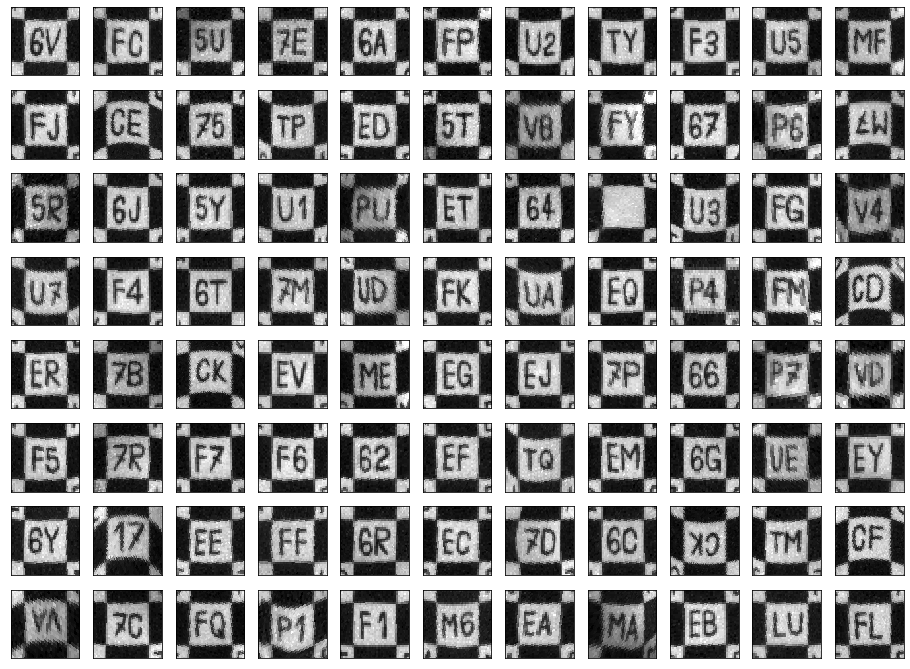

In [48]:
vis_data(accept2_imgs)

In [49]:
# below is output from the old rejector, v67:

In [50]:
accept_imgs.shape

(136, 104, 104, 1)

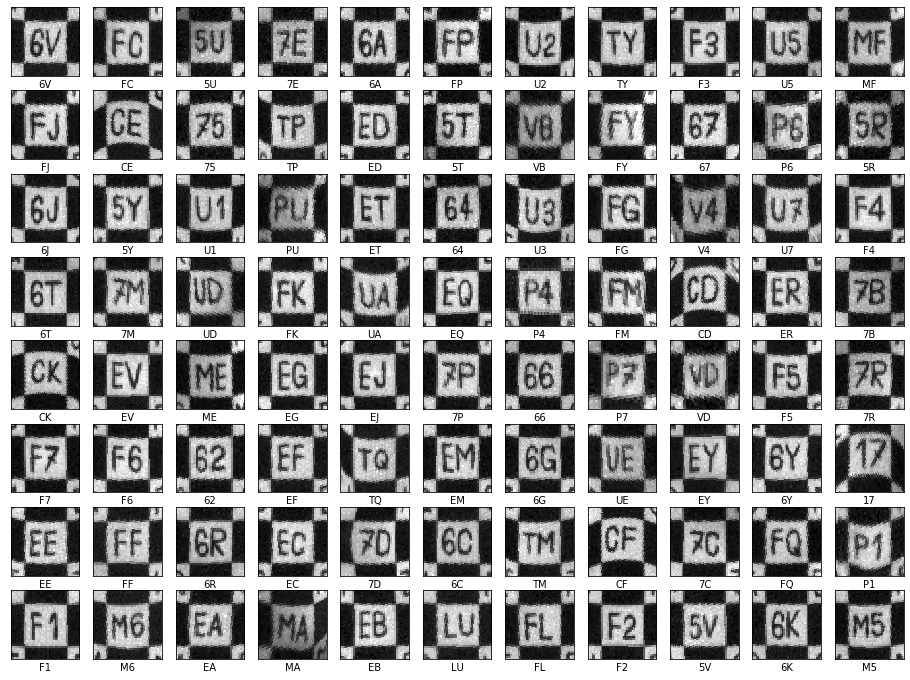

In [51]:
vis_data(accept_imgs, code_strs)

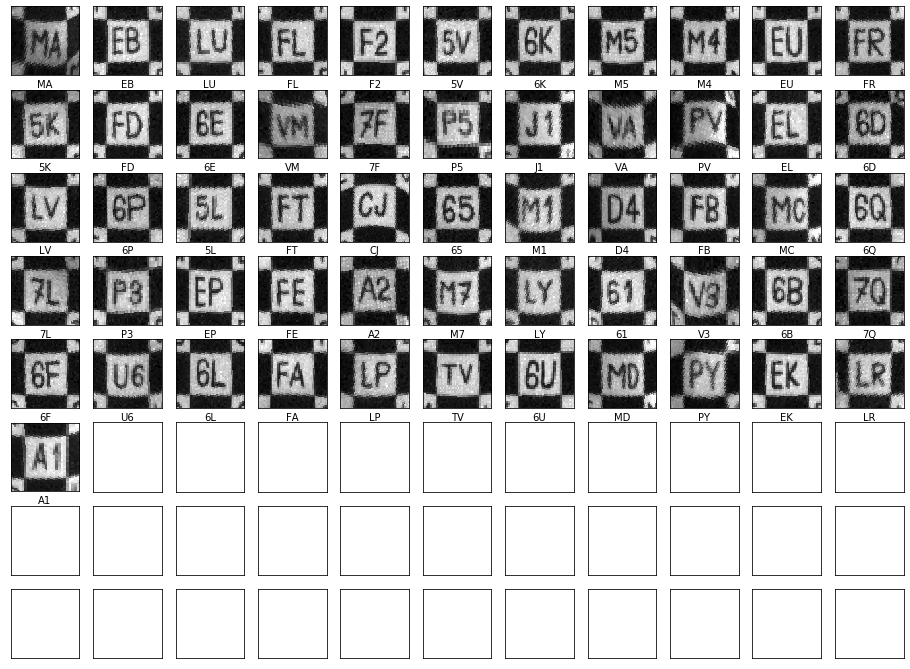

In [52]:
vis_data(accept_imgs, code_strs, 80)